# Positive breaks XGBoost model - local run with loop

### Peter R.
#### 2024-03-04

Note: Given that DRAC was down on Feb. 22 and 23, 2024, I had to run DRAC XGBoost models locally. Here I run XGB models in a loop in an attempt to be more efficient. I think I hould be able ti run all my models locally from now on.

Today (2024-03-04) I meet with MJF to discuss XGB model improvements. An important number of Bfast breaks have very wide confidence intervals (CIs) associated with the time of break. These CIs can range from about 1 month to 80+ months. These won't allow for high quality matching with yearly climate or disturbance data. For this reason, we decided to run XGB models with subsets of data, each subset have narrow CIs. We will run the following XGB models with the follwoing dataframe subsets:

1) Records with CIs shorter than 3 16-days data points (48 days or about 1.5 months)

2) Records with CIs shorter than 6 16-days data points (96 days or about 3 months)

3) Records with CIs shorter than 9 16-days data points (144 days or about 5 months)

4) Records with CIS shorter than 23 16-days data points (368 days or about 1 year)

Some questions to have in mind:

- How many matches with disturbance data do the above have?
- Why does forest age become the top ranking variable with VIFplust variable set?  This variable was number 10 in other previous XGB model.





In [170]:
# 2024-03-04
# Peter R.
# XGBoost script
# Positive breaks, n_estimators (number of trees)=1000 and with optimal parameter from DRAC model_bp1 & early stopping

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_trends\models\xgboost')


print("XGB version:", xgb.__version__)
print("positive breaks")


# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_positive_v3.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()

df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
# Df0: all records
#df2 = df11 # N=11969
# Df3: 1.5 months
df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude']> 500)] #N=40
# Df6: 3 months
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.2630137) & (df11['magnitude']> 500)] #N=168
# Df9: 5 months, version 4
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.3945205) & (df11['magnitude']>500)] #N=649
# Df23: 12 months, 1 year, version 5
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude']>500)] #N=2216

XGB version: 1.7.6
positive breaks


In [157]:
# Subset data frame as per above
# Df1: 1.5 months
#print(df2.loc[(df2['brkdate95']-df2['brkdate25'] <= 0.1315068) & (df2['magnitude']>500)].describe()) #N=40
# Df2: 3 months
#print(df2.loc[(df2['brkdate95']-df2['brkdate25'] <= 0.2630137) & (df2['magnitude']>500)].describe()) #N=168
# Df3: 5 months
#print(df2.loc[(df2['brkdate95']-df2['brkdate25'] <= 0.3945205) & (df2['magnitude']>500)].describe()) #N=649
# Df4: 12 months, 1 year
#print(df2.loc[(df2['brkdate95']-df2['brkdate25'] <= 1.008219) & (df2['magnitude']>500)].describe()) #N=2216



In [171]:
#print(df2[['canlad_year']].describe())#
#print(df2[['hansen_year']].describe())#
print(df2.describe())
df2.shape

                 pix         year   brk    brkdate25      brkdate  \
count      40.000000    40.000000  40.0    40.000000    40.000000   
mean   139102.825000  2016.000000   0.0  2016.395425  2016.446875   
std    139930.570707     4.695879   0.0     4.536633     4.528368   
min      4945.000000  2005.000000   0.0  2005.652000  2005.696000   
25%     58459.000000  2017.000000   0.0  2017.293250  2017.348000   
50%     79476.000000  2018.000000   0.0  2018.304000  2018.348000   
75%    136847.750000  2019.000000   0.0  2019.304000  2019.348000   
max    480012.000000  2020.000000   0.0  2020.304000  2020.348000   

         brkdate95    magnitude  no_brk  fire_year  harv_year  ...  \
count    40.000000    40.000000     0.0        0.0        0.0  ...   
mean   2016.497725  2429.232600     NaN        NaN        NaN  ...   
std       4.525511   662.991591     NaN        NaN        NaN  ...   
min    2005.783000   508.166000     NaN        NaN        NaN  ...   
25%    2017.391000  2194.173

(40, 158)

MSE: 92064.40
RMSE: 303.42
R-sq: 0.069
R-sq-adj: 7.053
7.053146672802484
| 92064.40 | 303.42 | 0.069 | 7.053 | 40 | 15 |


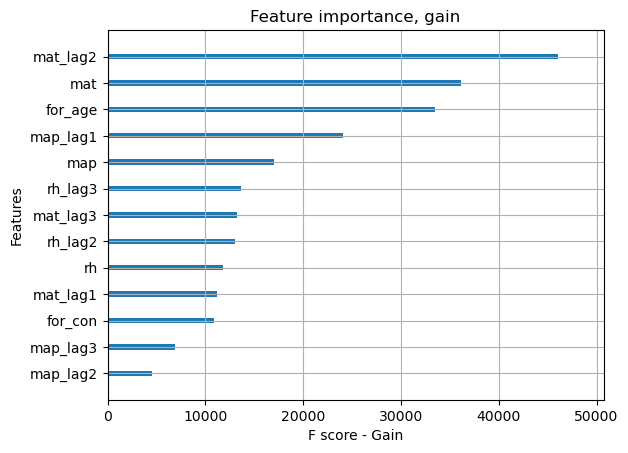

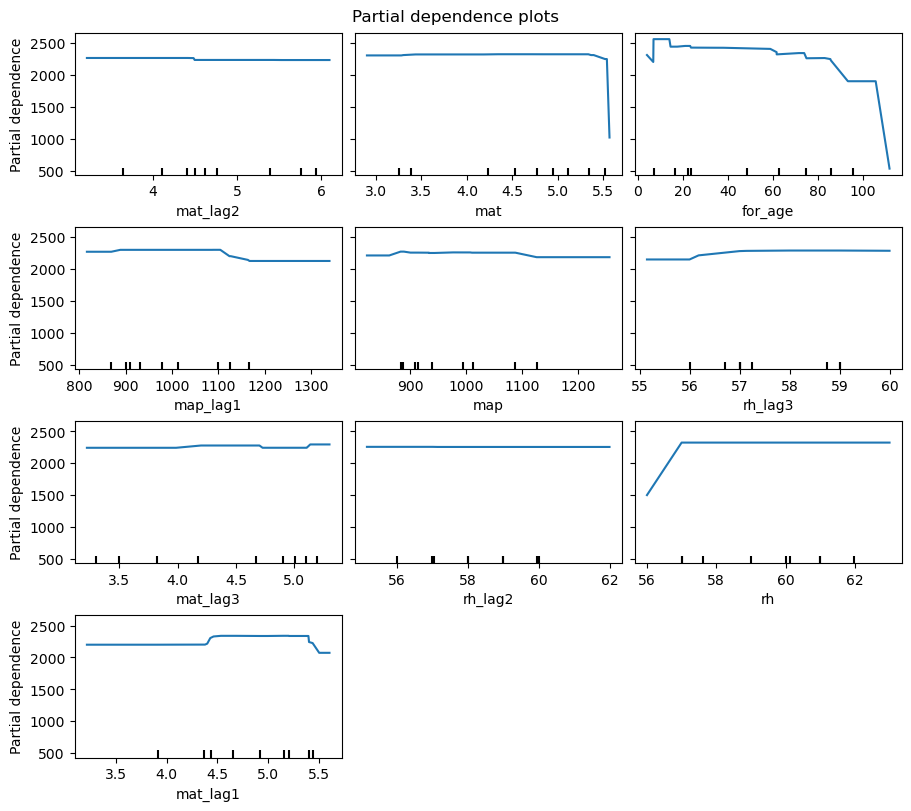

MSE: 961633.21
RMSE: 980.63
R-sq: -8.727
R-sq-adj: -20.075
-20.075489016147273
| 961633.21 | 980.63 | -8.727 | -20.075 | 40 | 7 |


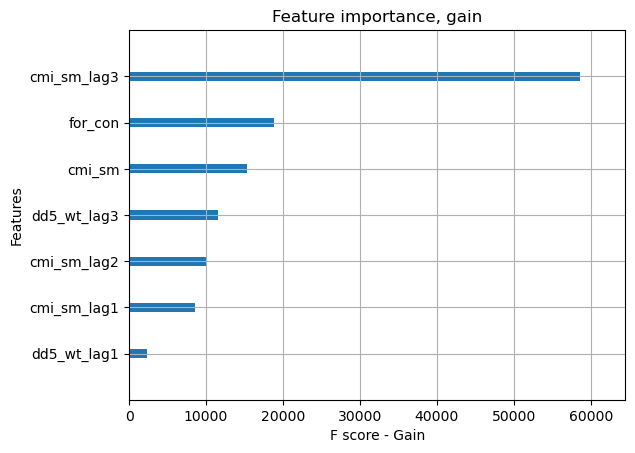

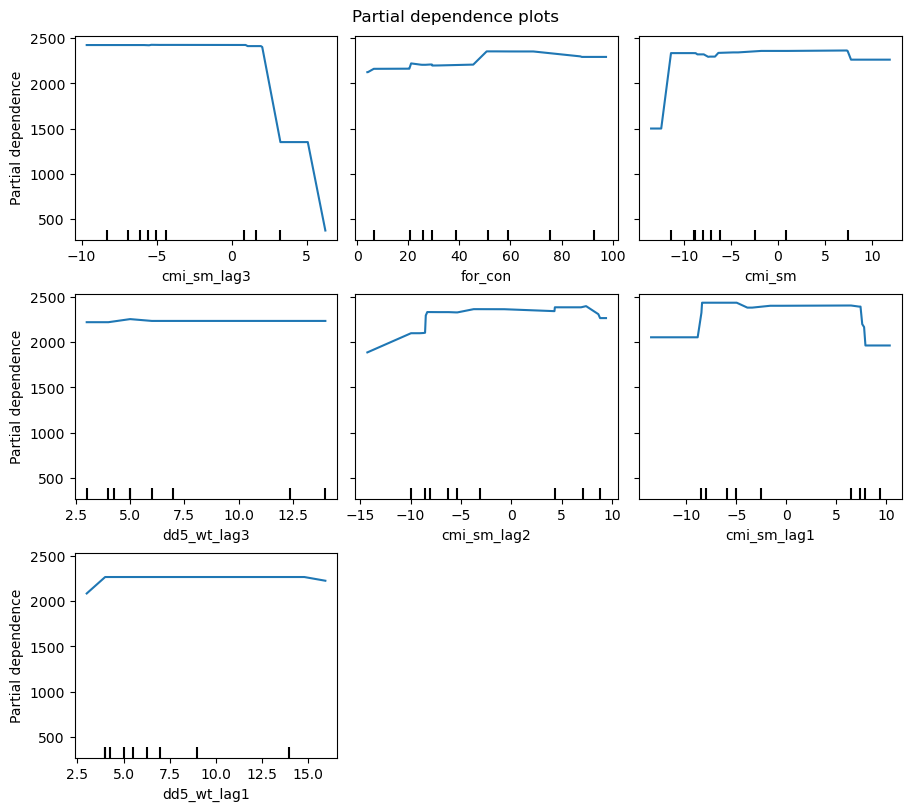

MSE: 983816.48
RMSE: 991.88
R-sq: -8.952
R-sq-adj: -31.342
-31.342497965349104
| 983816.48 | 991.88 | -8.952 | -31.342 | 40 | 9 |


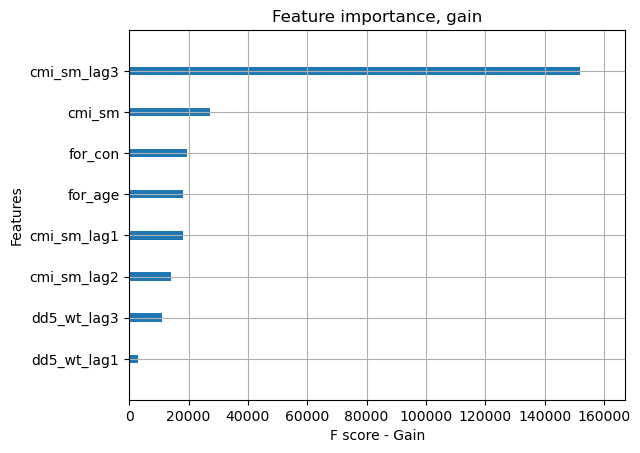

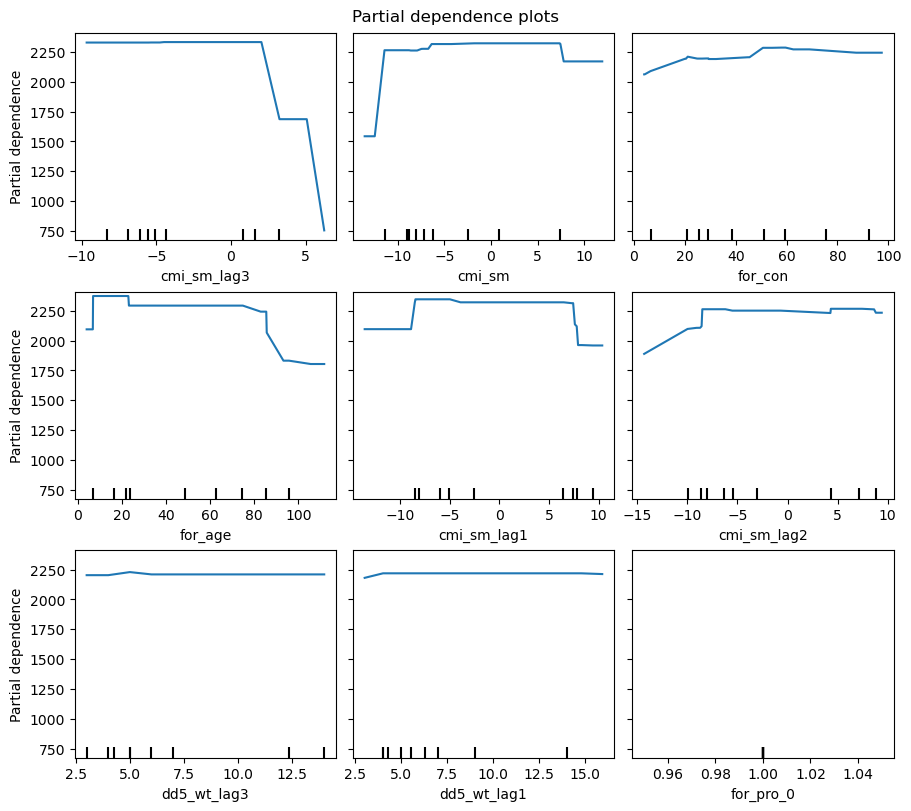

In [173]:
# loop version
# 2024-03-04
# Only cols3 will be run as it produces results with the highest R-square adjusted.

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']


list_of_vars = [[cols1], [cols2], [cols3]]
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6]
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)

        print("RMSE: %.2f" % (mse**(1/2.0)))

        print("R-sq: %.3f" % r2)

        print("R-sq-adj: %.3f" % adj_r2)
        print(adj_r2)
        
         # row for table
        print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
       
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version4\df3\pos_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version4\df3\pos_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
        pyplot.show()

**Table 1**: Model comparison for positive breaks. Standard data set with all records (including NAs for for_age and for_con).

|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
|1|df0| First variable set| 101545.85 | 318.66 | 0.331 | 0.323 | 3935 | 15 |
|2|df0| VIF variable set| 102425.49 | 320.04 | 0.325 | 0.321 | 3935 | 7 |
|3|df0| VIFplus variable set| 100565.73 | 317.12 | 0.337 | 0.333 | 3935 | 9 |
|4|df3| First variable set| 92064.40 | 303.42 | 0.069 | 7.053 | 40 | 15 |
|5|df3| VIF variable set| 961633.21 | 980.63 | -8.727 | -20.075 | 40 | 7 |
|6|df3| VIFplus variable set| 983816.48 | 991.88 | -8.952 | -31.342 | 40 | 9 |
|7|df6| First variable set| 429397.33 | 655.28 | 0.277 | 0.006 | 168 | 15 |
|8|df6| VIF variable set| 414451.90 | 643.78 | 0.302 | 0.200 | 168 | 7 |
|9|df6| VIFplus variable set| 446827.37 | 668.45 | 0.248 | 0.100 | 168 | 9 |
|10|df9| First variable set| 205022.31 | 452.79 | 0.168 | 0.105 | 649 | 15 |
|11|df9| VIF variable set| 187066.63 | 432.51 | 0.240 | 0.215 | 649 | 7 |
|12|df9| VIFplus variable set| 199167.64 | 446.28 | 0.191 | 0.156 | 649 | 9 |
|13|df23| First variable set| 108384.69 | 329.22 | 0.345 | 0.331 | 2216 | 15 |
|14|df23| VIF variable set| 117880.80 | 343.34 | 0.288 | 0.281 | 2216 | 7 |
|15|df23| VIFplus variable set| 106324.50 | 326.07 | 0.357 | 0.349 | 2216 | 9 |





In [199]:
#Describe the data
#print(X1.describe)

#import numpy as np
 #1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))
#print(r2)
#print(1-r2)
#print(40*0.33) # percent of records to test after training
#print(40*0.67) # percent of records to train
#print(len(y1_test)) # number of records
#print(len(x1_test)) # number of records
#print(len(y_pred)) # number of records
#print(len(y1_test)-1) # number of records minus 1
#print(x1_test.shape[1]) # number of columns
#print(len(y1_test)-x1_test.shape[1]-1) # denominator
#print(y1_test.describe())
#print(y_pred)
#plt.plot(y_pred, y1_test, 'o', color='black')

#coef = np.polyfit(y_pred, y1_test, 1)
#poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

#plt.plot(y_pred, y1_test, 'yo', y_pred, poly1d_fn(y_pred), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker

#plt.xlim(100, 3500)
#plt.ylim(100, 4000)
1 - (((1-0.069) * (14-1))/(14-15-1)) # odd R-sq-adj

7.051500000000001

In [161]:
# This did not work
# Feature importance plot
        #model = ['1','2','3']
        #for m in range(0,3):
            #xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
            #        xlabel='F score - Gain', ylabel='Features', 
            #        importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )
            #file_start='\figs\version3\pos_gain_m'
            #file_end='_v1.png'
            #filename = file_start+model[m]+file_end
            #pyplot.savefig('filename', dpi=300, bbox_inches='tight')
            #pyplot.close(fig)

In [162]:
#print(len(cols1))

In [163]:
# Count NAs per columns to check that step above worked #mat 607 before, now 0
#X1.isna().sum()

In [164]:
#X1.describe()

### Models without records that have disturbance matches

When dealing with positive forest EVI breaks, I can't remove records matched to Hansen et al.'s disturbance data as there are no such matched records. This makes sense as positive breaks should not be matched to disturbances.

I will need to recheck this as sometime Hansen matches are zero but other times >0.  There should be a low proportion of matches between disturbance data and Bfast positive breaks.  For dataframe 4 (N=2216) about 21% of quality positive breaks have a matche with disturbance data.

In [165]:
# How many records are matched to Hansen et al.'s data?
print(df2[['hansen_year']].describe()) # N=0
print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=0/457 with df4; Hansen=158 with df3

       hansen_year
count   672.000000
mean   2010.132440
std       4.531593
min    2004.000000
25%    2006.000000
50%    2009.000000
75%    2013.000000
max    2021.000000
         magnitude  fire_year    harv_year  canlad_year  hansen_year
count  3935.000000        0.0   102.000000   495.000000   672.000000
mean    802.658876        NaN  2010.009804  2008.101010  2010.132440
std     390.213785        NaN     4.390573     3.138809     4.531593
min      81.806000        NaN  2004.000000  2004.000000  2004.000000
25%     535.356000        NaN  2006.000000  2005.000000  2006.000000
50%     724.616000        NaN  2010.500000  2008.000000  2009.000000
75%     969.261500        NaN  2013.000000  2011.000000  2013.000000
max    3606.961000        NaN  2019.000000  2015.000000  2021.000000


Matches when using CanLaD

In [166]:
#print(df2[['canlad_year']].describe()) # 66
#print(df2[['harv_year']].describe()) # 4
#print(df2[['fire_year']].describe()) # 0
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe())

In [167]:
# This produces an empty df as there are no records
#X3 = df2.loc(df2['hansen_year' > 0]) 
#X3 = df2.loc[(df2['magnitude'] > 0)]
#X3.tail
#X3.shape
#X3.describe

In [168]:
df2 = df2.loc[df2['hansen_year'].isnull()]

df2.shape

(3263, 158)

MSE: 96438.93
RMSE: 310.55
R-sq: 0.357
R-sq-adj: 0.348
| 96438.93 | 310.55 | 0.357 | 0.348 | 3263 | 15 |


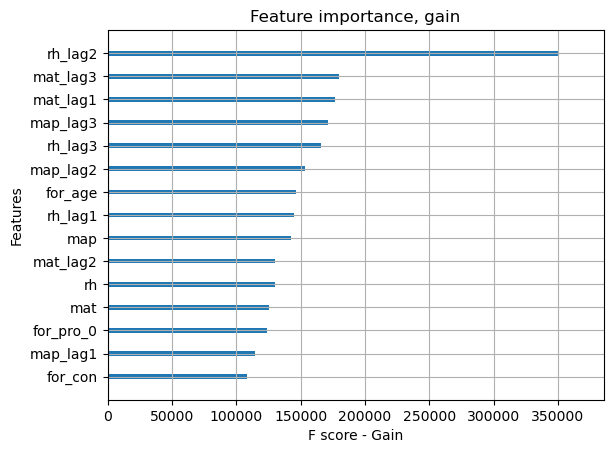

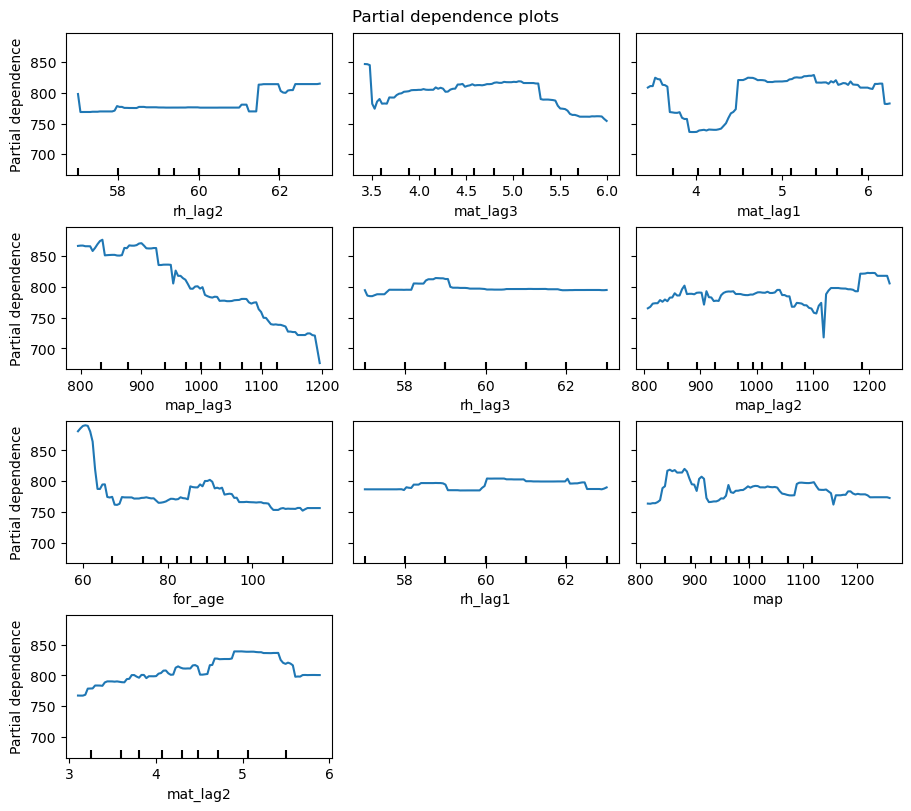

MSE: 97848.66
RMSE: 312.81
R-sq: 0.348
R-sq-adj: 0.344
| 97848.66 | 312.81 | 0.348 | 0.344 | 3263 | 7 |


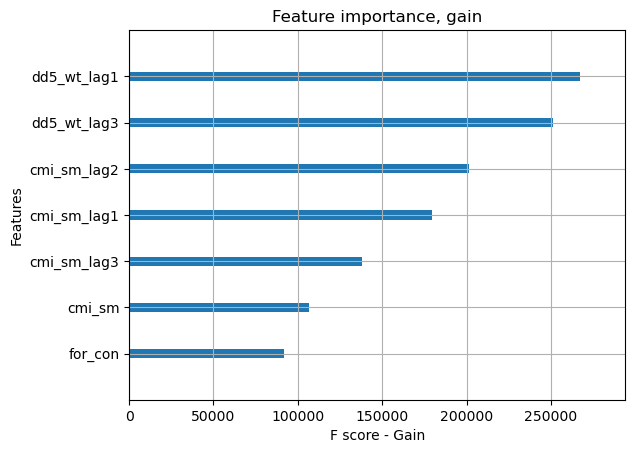

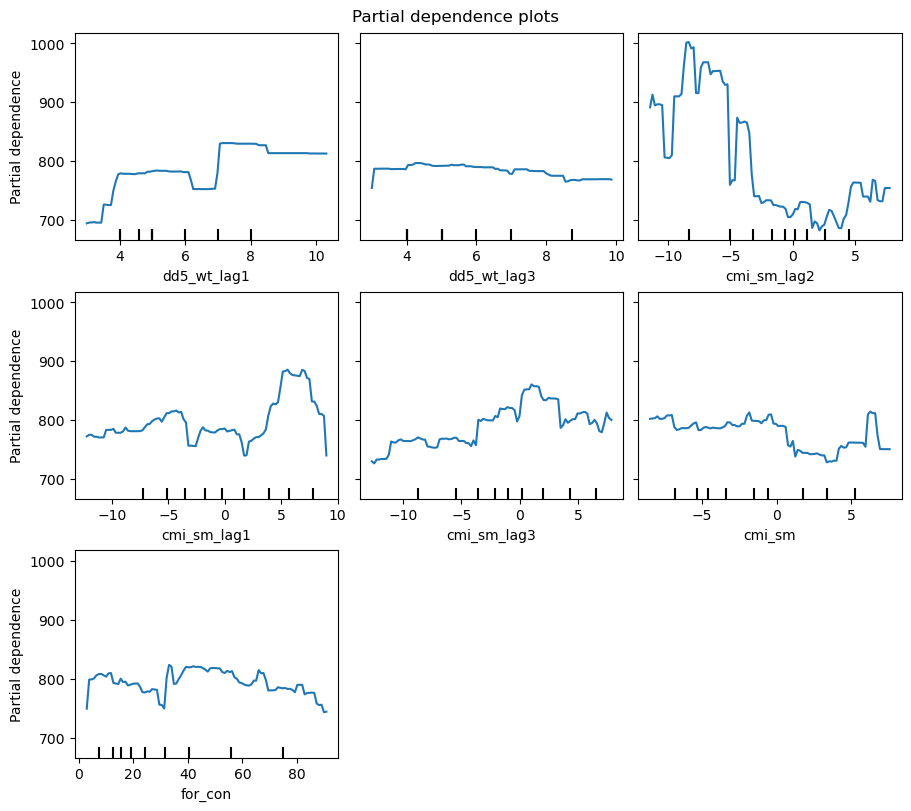

MSE: 96362.44
RMSE: 310.42
R-sq: 0.358
R-sq-adj: 0.352
| 96362.44 | 310.42 | 0.358 | 0.352 | 3263 | 9 |


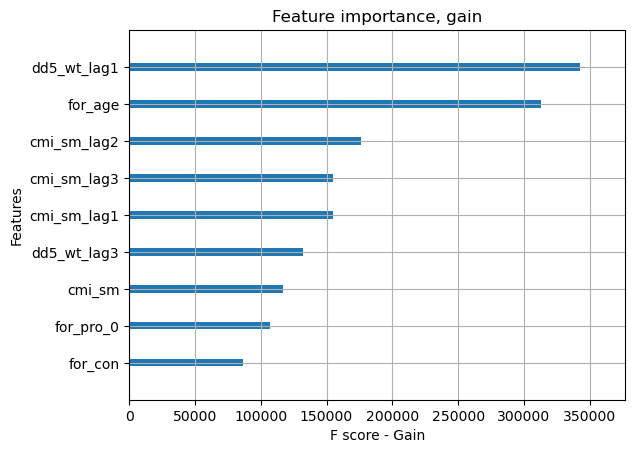

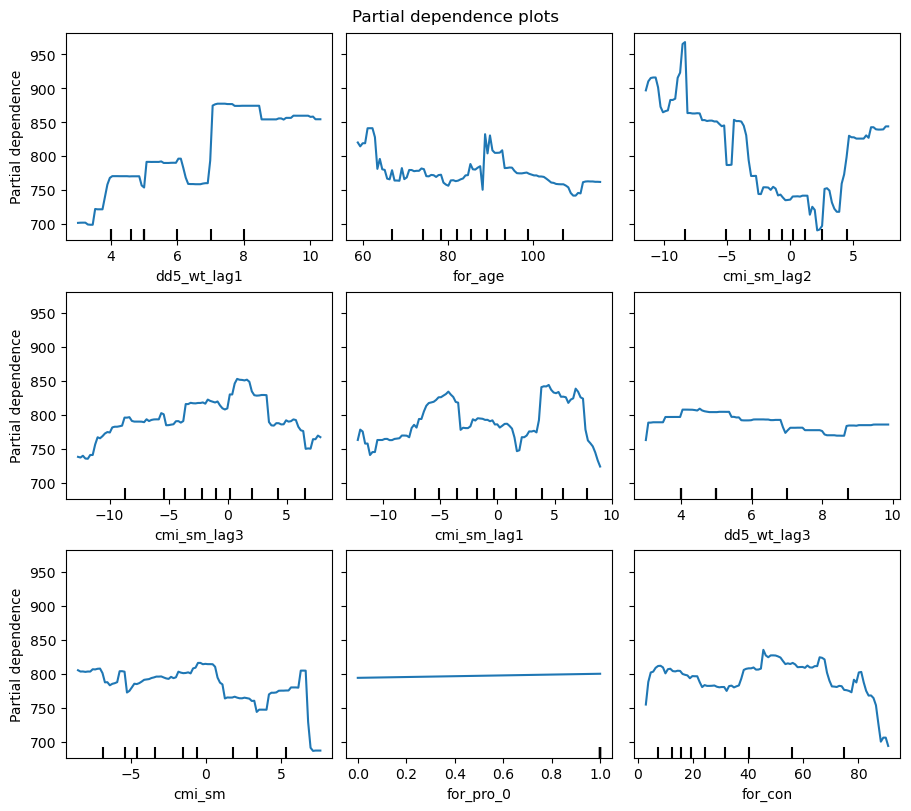

In [169]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']


list_of_vars = [ [cols1], [cols2], [cols3]]
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6].abs()
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)

        print("RMSE: %.2f" % (mse**(1/2.0)))

        print("R-sq: %.3f" % r2)

        print("R-sq-adj: %.3f" % adj_r2)
        
         # row for table
        print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version4\df0\pos_gain_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version4\df0\pos_partial_dep_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
        pyplot.show()

**Table 2**: Model comparison for positive breaks. Subset of data records was used, excluding records that had a match with disturbance data. (Some NAs for for_age and for_con.)


|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
|1|df0| First variable set| 96438.93 | 310.55 | 0.357 | 0.348 | 3263 | 15 |
|2|df0| VIF variable set| 97848.66 | 312.81 | 0.348 | 0.344 | 3263 | 7 |
|3|df0| VIFplus variable set| 96362.44 | 310.42 | 0.358 | 0.352 | 3263 | 9 |
|4|df3| First variable set| 357922.16 | 598.27 | -0.676 | 5.608 | 35 | 15 |
|5|df3| VIF variable set| 290250.79 | 538.75 | -0.359 | -2.737 | 35 | 7 |
|6|df3| VIFplus variable set| 467376.91 | 683.65 | -1.188 | -11.034 | 35 | 9 |
|7|df6| First variable set| 627128.07 | 791.91 | 0.012 | -0.537 | 130 | 15 |
|8|df6| VIF variable set| 559673.88 | 748.11 | 0.118 | -0.058 | 130 | 7 |
|9|df6| VIFplus variable set| 555182.14 | 745.11 | 0.125 | -0.113 | 130 | 9 |
|10|df9| First variable set| 205262.67 | 453.06 | 0.169 | 0.084 | 491 | 15 |
|11|df9| VIF variable set| 209576.92 | 457.80 | 0.151 | 0.113 | 491 | 7 |
|12|df9| VIFplus variable set| 212155.69 | 460.60 | 0.141 | 0.090 | 491 | 9 |
|13|df23| First variable set| 105563.15 | 324.90 | 0.243 | 0.222 | 1759 | 15 |
|14|df23| VIF variable set| 120538.11 | 347.19 | 0.135 | 0.125 | 1759 | 7 |
|15|df23| VIFplus variable set| 109900.17 | 331.51 | 0.211 | 0.199 | 1759 | 9 |
